In [13]:
using Revise
using AllenCahn
using Plots

In [14]:
# Construct the problem with Neumann BCs
a = 0; b = 1
ϵ = 0.1
nₓ = 9
nₜ = 100; t_max = 1
left_bc = NeumannBC(0); right_bc = NeumannBC(0)
u₀(x) = 1.
problem = AllenCahnProblem1D(a, b, ϵ, nₓ, nₜ, t_max, left_bc, right_bc, u₀);

In [15]:
# Check that the problem constructor works
println("a: $(problem.a), b: $(problem.b), ϵ: $(problem.ϵ), Δx: $(problem.Δx) Δt: $(problem.Δt)")
println("mesh: $(problem.x)")

a: 0, b: 1, ϵ: 0.1, Δx: 0.1 Δt: 0.01
mesh: [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]


In [16]:
# Assembly and check
assemble_system!(problem);
println("A: $(problem.A)")
println("RHS: $(problem.rhs)")

A: 
 -200.0   200.0      ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅ 
  100.0  -200.0   100.0      ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅ 
     ⋅    100.0  -200.0   100.0      ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅ 
     ⋅       ⋅    100.0  -200.0   100.0      ⋅       ⋅       ⋅       ⋅       ⋅       ⋅ 
     ⋅       ⋅       ⋅    100.0  -200.0   100.0      ⋅       ⋅       ⋅       ⋅       ⋅ 
     ⋅       ⋅       ⋅       ⋅    100.0  -200.0   100.0      ⋅       ⋅       ⋅       ⋅ 
     ⋅       ⋅       ⋅       ⋅       ⋅    100.0  -200.0   100.0      ⋅       ⋅       ⋅ 
     ⋅       ⋅       ⋅       ⋅       ⋅       ⋅    100.0  -200.0   100.0      ⋅       ⋅ 
     ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅    100.0  -200.0   100.0      ⋅ 
     ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅    100.0  -200.0   100.0
     ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅    200.0  -200.0
RHS: [0.0, 0.0, 0.0, 0.0, 0.

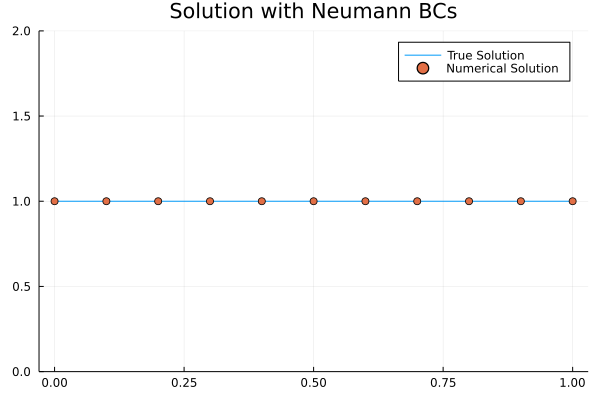

In [17]:
# Solve problem and plot solution vs. expected result
u = solve(problem, BackwardEulerMethod())
u_true(x) = 1.
plot(problem.x, u_true.(problem.x), label = "True Solution", title = "Solution with Neumann BCs", ylims = (0, 2))
scatter!(problem.x, u, label = "Numerical Solution")

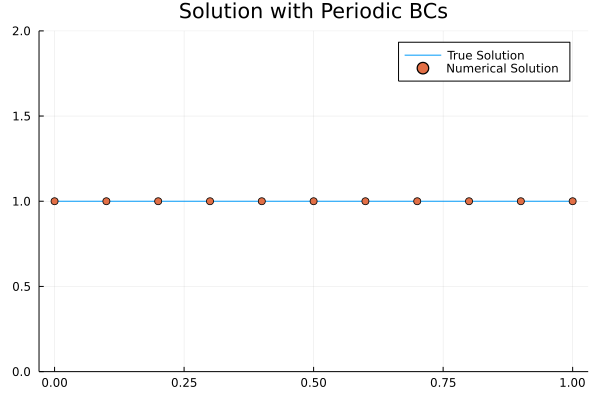

In [18]:
# Construct and solve problem with Periodic BCs
a = 0; b = 1
ϵ = 0.1
nₓ = 9
nₜ = 100; t_max = 1
left_bc = PeriodicBC(); right_bc = PeriodicBC()
u₀(x) = 1.
problem = AllenCahnProblem1D(a, b, ϵ, nₓ, nₜ, t_max, left_bc, right_bc, u₀);

assemble_system!(problem);
u = solve(problem, BackwardEulerMethod())
plot(problem.x, u_true.(problem.x), label = "True Solution", title = "Solution with Periodic BCs", ylims = (0, 2))
scatter!(problem.x, u, label = "Numerical Solution")

In [19]:
# Use a test to check that the package passes
using Pkg
Pkg.test("AllenCahn")

     Testing AllenCahn
      Status `/private/var/folders/1d/xcpc4m2d0c7_b8jv3tx1xzfr0000gn/T/jl_JiJCW6/Project.toml`
  [b543f458] AllenCahn v0.1.0 `~/github/AllenCahn`
  [37e2e46d] LinearAlgebra `@stdlib/LinearAlgebra`
  [2f01184e] SparseArrays `@stdlib/SparseArrays`
  [8dfed614] Test `@stdlib/Test`
      Status `/private/var/folders/1d/xcpc4m2d0c7_b8jv3tx1xzfr0000gn/T/jl_JiJCW6/Manifest.toml`
  [b543f458] AllenCahn v0.1.0 `~/github/AllenCahn`
  [2a0f44e3] Base64 `@stdlib/Base64`
  [b77e0a4c] InteractiveUtils `@stdlib/InteractiveUtils`
  [8f399da3] Libdl `@stdlib/Libdl`
  [37e2e46d] LinearAlgebra `@stdlib/LinearAlgebra`
  [56ddb016] Logging `@stdlib/Logging`
  [d6f4376e] Markdown `@stdlib/Markdown`
  [9a3f8284] Random `@stdlib/Random`
  [9e88b42a] Serialization `@stdlib/Serialization`
  [2f01184e] SparseArrays `@stdlib/SparseArrays`
  [8dfed614] Test `@stdlib/Test`
Precompiling project...
  ✓ AllenCahn
1 dependency successfully precompiled in 2 seconds
     Testing Running tests...


Test Summary: | Pass  Total
Neumann       |    1      1
Test Summary: | Pass  Total
Periodic      |    1      1


     Testing AllenCahn tests passed 
